### Imports

Perform necessary imports and preparation

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import torchvision
import numpy as np

from torchviz import make_dot
from tqdm import tqdm

import matplotlib.pyplot as plt

from skindataset import SkinDataset
from skindiffuser import NoiseScheduler, SkinUnet
from util import HParams

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Notebook is running on device: {device}')

Notebook is running on device: cuda


For easier tuning and experimentation regarding hyperparameters, we outsource them into a json file. The following utility class loads the values and makes the accessible to the code

In [3]:
hparams = HParams()
hparams

{'T': 600, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 128}

### Load Data

We use an extensive dataset of +900'000 minecraft skins to train our diffusion model. The data was sourced from

https://www.kaggle.com/datasets/sha2048/minecraft-skin-dataset/code

and underlies the CC0: Public Domain License.

Load the dataset and create a dataloader. We limit the number of loaded samples to $100'000$ for now

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Loaded dataset of 100000 samples with an 80/20 train test split (80000 train, 20000 test) training set has 625 batches and test set has 156 batches
Each batch contains 128 images of size 64x64


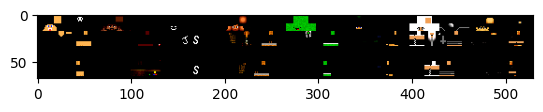

In [4]:
train_data, test_data = torch.utils.data.random_split(SkinDataset(number_of_samples=100000), [0.8, 0.2])

train_loader = DataLoader(train_data,
                          batch_size=hparams.data['batch_size'],
                          shuffle=True,
                          drop_last=True)

test_loader = DataLoader(test_data,
                         batch_size=hparams.data['batch_size'],
                         shuffle=True,
                         drop_last=True)

print(f"Loaded dataset of {len(train_data) + len(test_data)} samples \
with an 80/20 train test split ({len(train_data)} train, {len(test_data)} test) \
training set has {len(train_loader)} batches and test set has {len(test_loader)} batches")

img_batch = next(iter(train_loader))
print(f"Each batch contains {img_batch.size(0)} images of size {img_batch.size(2)}x{img_batch.size(3)}")

def imshow_grid(batch, num_images=8):
    if batch.size(0) < num_images:
        img_grid = torchvision.utils.make_grid(batch)
    else:
        img_grid = torchvision.utils.make_grid(batch[:num_images])
    npimg = img_grid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow_grid(img_batch, 8)


### Forward process

The forward diffusion process uses a basic noise scheduler

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.055728..4.1067605].


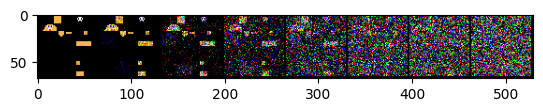

In [5]:
NUM_IMGS = 8
T = hparams.data['T']

ns = NoiseScheduler(T)
stepsize = int(T/NUM_IMGS)
out = torch.empty((NUM_IMGS+1, 3, 64, 64))
idx = 0
for i in range(0, T, stepsize):
    t = torch.tensor([i]).type(torch.int64)
    image, noise = ns.forward_sample(img_batch[0], t)
    out[idx] = image
    idx += 1

imshow_grid(out, NUM_IMGS)

### Backward process

The backward process is a simple Unet architecture. For details on implementation consult ```skindiffuser.py```

In [6]:
unet = SkinUnet()
print(f"Num params: {sum(p.numel() for p in unet.parameters())}")
print(unet)

# Visualize the model
# NOTE: Visualization is too large to render in Jupyter. PNG file is provided in the repo.
#make_dot(unet(img_batch, torch.randint(0, 200, (256,)).long()), params=dict(list(unet.named_parameters()))).render("unet", format="png")

Num params: 62438883
SkinUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

### Training loop

We define a simple l1 loss on the predicted noise at time step $t$

In [7]:
def training_loss(model, x_0, t):
    x_noisy, noise = ns.forward_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [23]:
@torch.no_grad()
def sample_timestep(x, t, unet):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = NoiseScheduler.get_index_from_list(ns.betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = NoiseScheduler.get_index_from_list(
        ns.sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = NoiseScheduler.get_index_from_list(ns.sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * unet(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = NoiseScheduler.get_index_from_list(ns.posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
    

The main training loop. We attach the unet to the training device and train it under a simple adam optimizer

Epoch 0 - Train Loss: 0.1909 - Val Loss: 0.1278


Epoch 1 - Train Loss: 0.1178 - Val Loss: 0.1126


Epoch 2 - Train Loss: 0.1060 - Val Loss: 0.1083


Epoch 3 - Train Loss: 0.0981 - Val Loss: 0.0973


Epoch 4 - Train Loss: 0.0942 - Val Loss: 0.0960


Epoch 5 - Train Loss: 0.0905 - Val Loss: 0.0954


Epoch 6 - Train Loss: 0.0888 - Val Loss: 0.0898


Epoch 7 - Train Loss: 0.0908 - Val Loss: 2.2451


Epoch 8 - Train Loss: 0.0855 - Val Loss: 0.2775


Epoch 9 - Train Loss: 0.0842 - Val Loss: 108412685.5402


Epoch 10 - Train Loss: 0.0832 - Val Loss: 5302291.4619


Epoch 11 - Train Loss: 0.0819 - Val Loss: 0.2037


Epoch 12 - Train Loss: 0.0806 - Val Loss: 2264201.2632


Epoch 13 - Train Loss: 0.0808 - Val Loss: 335.1308


Epoch 14 - Train Loss: 0.0792 - Val Loss: 69.5511


Epoch 15 - Train Loss: 0.0781 - Val Loss: 9542266.1852


Epoch 16 - Train Loss: 0.0782 - Val Loss: 6329.6629


Epoch 17 - Train Loss: 0.0779 - Val Loss: 6432.2125


Epoch 18 - Train Loss: 0.0766 - Val Loss: 5968314.8994


Epoch 19 - Train Loss: 0.0765 - Val Loss: 500455972.7591


Epoch 20 - Train Loss: 0.0760 - Val Loss: 3635473284.2070


Epoch 21 - Train Loss: 0.0751 - Val Loss: 24514525.6567


Epoch 22 - Train Loss: 0.0749 - Val Loss: 460755991641.6982


Epoch 23 - Train Loss: 0.0747 - Val Loss: 12239710.8839


Epoch 24 - Train Loss: 0.0747 - Val Loss: 5433959.5088


Epoch 25 - Train Loss: 0.0737 - Val Loss: 9066595.0274


Epoch 26 - Train Loss: 0.0734 - Val Loss: 101517996.0840


Epoch 27 - Train Loss: 0.0738 - Val Loss: 1580284709.6993


Epoch 28 - Train Loss: 0.0741 - Val Loss: 580569.8976


Epoch 29 - Train Loss: 0.0744 - Val Loss: 38231119721733360.0000


Epoch 30 - Train Loss: 0.0725 - Val Loss: 107828051585.6416


Epoch 31 - Train Loss: 0.0718 - Val Loss: 6757164422.0396


Epoch 32 - Train Loss: 0.0719 - Val Loss: 110650243.4059


Epoch 33 - Train Loss: 0.0710 - Val Loss: 732787932903.0728


Epoch 34 - Train Loss: 0.0714 - Val Loss: 167384352148.0594


Epoch 35 - Train Loss: 0.0796 - Val Loss: 22589973268.4119


Epoch 36 - Train Loss: 0.0733 - Val Loss: 41577408453014720.0000


Epoch 37 - Train Loss: 0.0716 - Val Loss: 34830225322863.4375


Epoch 38 - Train Loss: 0.0717 - Val Loss: 87383526.8465


Epoch 39 - Train Loss: 0.0717 - Val Loss: 830019334457158.0000


Epoch 40 - Train Loss: 0.0713 - Val Loss: 164711339120.1835


Epoch 41 - Train Loss: 0.0722 - Val Loss: 4974619.0402


Epoch 42 - Train Loss: 0.0852 - Val Loss: 1128500.3193


Epoch 43 - Train Loss: 0.0760 - Val Loss: 621.0734


Epoch 44 - Train Loss: 0.0734 - Val Loss: 11539305.8766


Epoch 45 - Train Loss: 0.0721 - Val Loss: 2376761.4839


Epoch 46 - Train Loss: 0.0763 - Val Loss: 35.6252


Epoch 47 - Train Loss: 0.0736 - Val Loss: 259265.2748


Epoch 48 - Train Loss: 0.0713 - Val Loss: 10274306.6588


Epoch 49 - Train Loss: 0.0706 - Val Loss: 6529.8231


Epoch 50 - Train Loss: 0.0701 - Val Loss: 12451459.3374


Epoch 51 - Train Loss: 0.0697 - Val Loss: 42062836777551.2344


Epoch 52 - Train Loss: 0.0697 - Val Loss: 55948.1263


Epoch 53 - Train Loss: 0.0691 - Val Loss: 4011104.3787


Epoch 54 - Train Loss: 0.0710 - Val Loss: 1300.8918


Epoch 55 - Train Loss: 0.0707 - Val Loss: 0.1323


Epoch 56 - Train Loss: 0.0735 - Val Loss: 0.5469


Epoch 57 - Train Loss: 0.0699 - Val Loss: 0.3146


Epoch 58 - Train Loss: 0.0691 - Val Loss: 158.9641


Epoch 59 - Train Loss: 0.0703 - Val Loss: 23.0153


Epoch 60 - Train Loss: 0.0721 - Val Loss: 0.1590


Epoch 61 - Train Loss: 0.0690 - Val Loss: 120.0871


Epoch 62 - Train Loss: 0.0684 - Val Loss: 1471194.2595


Epoch 63 - Train Loss: 0.0685 - Val Loss: 23032782.0725


Epoch 64 - Train Loss: 0.0680 - Val Loss: 687310.4991


Epoch 65 - Train Loss: 0.0727 - Val Loss: 16028.9274


Epoch 66 - Train Loss: 0.0693 - Val Loss: 1588335.5319


Epoch 67 - Train Loss: 0.0678 - Val Loss: 11794.8076


Epoch 68 - Train Loss: 0.0680 - Val Loss: 15293.9595


Epoch 69 - Train Loss: 0.0675 - Val Loss: 7878.0140


Epoch 70 - Train Loss: 0.0678 - Val Loss: 6325959.8029


Epoch 71 - Train Loss: 0.0697 - Val Loss: 1.8925


Epoch 72 - Train Loss: 0.0676 - Val Loss: 164.4256


Epoch 73 - Train Loss: 0.0680 - Val Loss: 41.7448


Epoch 74 - Train Loss: 0.0671 - Val Loss: 66.2028


Epoch 75 - Train Loss: 0.0675 - Val Loss: 5.6578


Epoch 76 - Train Loss: 0.0673 - Val Loss: 0.6923


Epoch 77 - Train Loss: 0.0671 - Val Loss: 2572077.1391


Epoch 78 - Train Loss: 0.0673 - Val Loss: 23639.0246


Epoch 79 - Train Loss: 0.0686 - Val Loss: 297731.2342


Epoch 80 - Train Loss: 0.0671 - Val Loss: 590112.5165


Epoch 81 - Train Loss: 0.0675 - Val Loss: 11104.7922


Epoch 82 - Train Loss: 0.0680 - Val Loss: 73391137.0515


Epoch 83 - Train Loss: 0.0668 - Val Loss: 7416925.8750


Epoch 84 - Train Loss: 0.0660 - Val Loss: 23478419.0562


Epoch 85 - Train Loss: 0.0663 - Val Loss: 523271.2255


Epoch 86 - Train Loss: 0.0667 - Val Loss: 2.3265


Epoch 87 - Train Loss: 0.0663 - Val Loss: 1207.4379


Epoch 88 - Train Loss: 0.0659 - Val Loss: 2213.0768


Epoch 89 - Train Loss: 0.0667 - Val Loss: 0.1319


Epoch 90 - Train Loss: 0.0662 - Val Loss: 825694.0584


Epoch 91 - Train Loss: 0.0661 - Val Loss: 69.8770


Epoch 92 - Train Loss: 0.0693 - Val Loss: 16.2708


Epoch 93 - Train Loss: 0.0668 - Val Loss: 218232.2493


Epoch 94 - Train Loss: 0.0657 - Val Loss: 11540.6147


Epoch 95 - Train Loss: 0.0675 - Val Loss: 2.6332


Epoch 96 - Train Loss: 0.0654 - Val Loss: 63276.4468


Epoch 97 - Train Loss: 0.0655 - Val Loss: 7817.2122


Epoch 98 - Train Loss: 0.0656 - Val Loss: 249.8374


Epoch 99 - Train Loss: 0.0657 - Val Loss: 1641364.4548


Epoch 100 - Train Loss: 0.0657 - Val Loss: 9277438.8804


Epoch 101 - Train Loss: 0.0654 - Val Loss: 564025.7501


Epoch 102 - Train Loss: 0.0653 - Val Loss: 915.1859


Epoch 103 - Train Loss: 0.0649 - Val Loss: 164025.7928


Epoch 104 - Train Loss: 0.0651 - Val Loss: 203.9777


Epoch 105 - Train Loss: 0.0650 - Val Loss: 20245987.5443


Epoch 106 - Train Loss: 0.0657 - Val Loss: 71250142.6847


Epoch 107 - Train Loss: 0.0651 - Val Loss: 721.0850


Epoch 108 - Train Loss: 0.0645 - Val Loss: 1612940135.1275


Epoch 109 - Train Loss: 0.0645 - Val Loss: 26535058.0449


Epoch 110 - Train Loss: 0.0646 - Val Loss: 196.4982


Epoch 111 - Train Loss: 0.0650 - Val Loss: 56845838.4196


Epoch 112 - Train Loss: 0.0648 - Val Loss: 374.4846


Epoch 113 - Train Loss: 0.0645 - Val Loss: 25.2903


Epoch 114 - Train Loss: 0.0647 - Val Loss: 3.2557


Epoch 115 - Train Loss: 0.0646 - Val Loss: 67.1276


Epoch 116 - Train Loss: 0.0645 - Val Loss: 92.1148


Epoch 117 - Train Loss: 0.0645 - Val Loss: 890410.1354


Epoch 118 - Train Loss: 0.0642 - Val Loss: 253.5881


Epoch 119 - Train Loss: 0.0642 - Val Loss: 2139255.1968


Epoch 120 - Train Loss: 0.0642 - Val Loss: 12545.9474


Epoch 121 - Train Loss: 0.0642 - Val Loss: 1852.5221


Epoch 122 - Train Loss: 0.0641 - Val Loss: 70664.8950


Epoch 123 - Train Loss: 0.0639 - Val Loss: 48063535.2319


Epoch 124 - Train Loss: 0.0642 - Val Loss: 263.7263


Epoch 125 - Train Loss: 0.0636 - Val Loss: 93907.1779


Epoch 126 - Train Loss: 0.0636 - Val Loss: 10014488.7555


Epoch 127 - Train Loss: 0.0639 - Val Loss: 4354020.4079


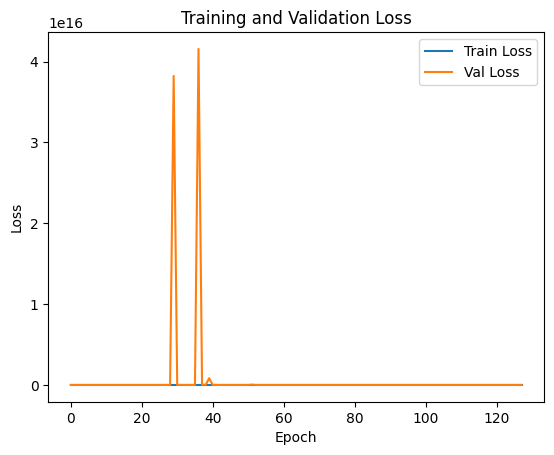

In [ ]:
unet.to(device)
optimizer = Adam(unet.parameters(), lr=hparams.data['learning_rate'])
epochs = hparams.data['epochs']

train_losses = []

for epoch in range(epochs):

    # Wrap train_loader with tqdm for the inner loop
    progress_bar = tqdm(train_loader, desc=f"\033[96mTraining Epoch {epoch}\033[0m", leave=False)

    # ---------------
    # TRAINING LOOP
    # ---------------
    unet.train()
    train_loss = 0
    for step, batch in enumerate(progress_bar):
        optimizer.zero_grad()
        
        t = torch.randint(0, hparams.data["T"], # Sample uniformly from [0, T)
                          (hparams.data["batch_size"],), # of shape (batch_size,)
                          device=device).long()
        

        train_loss_batch = training_loss(unet, batch, t)
        train_loss += train_loss_batch.item()
        train_loss_batch.backward()
        optimizer.step()

        # Update tqdm bar with the current loss
        progress_bar.set_postfix(loss=train_loss_batch.item())


    # Save model checkpoint
    if epoch % 25 == 0:
        torch.save(unet.state_dict(), f"checkpoints/unet_epoch_{epoch}.pt")

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()
            

### Inference test

To infer new images with the trained model, we generate random noise and iteratively denoise it through the unet

In [19]:
device = 'cuda'

In [20]:
model = SkinUnet()
model.load_state_dict(torch.load("checkpoints/unet_epoch_125.pt"))
model.to(device)
model.eval()

SkinUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0852019..1.2297682].


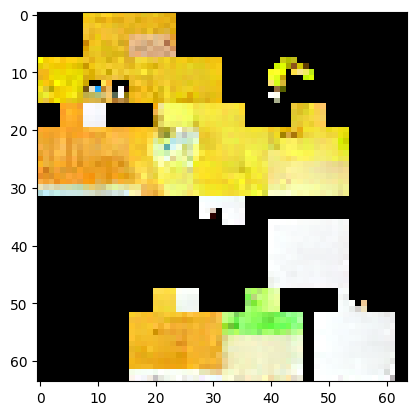

In [34]:
# Sample noise
img = torch.randn((1, 3, 64, 64), device=device)

for i in range(hparams.data['T'])[::-1]:
    t = torch.full((1,), i, device=device).long()
    img = sample_timestep(img, torch.tensor([i]).long().to(device), model)

npimg = img[0].cpu().numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
